<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="200"/>
        <br>
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://arize.com/docs/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-2w57bhem8-hq24MB6u7yE_ZF_ilOYSBw#/shared-invite/email">Community</a>
    </p>
</center>
<h1 align="center">Agent Tool Calling Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to evaluating agent tool calling,
- to provide an experimental framework for users to iterate and improve on the default agent tool calling template.

## Install Dependencies and Import Libraries

In [1]:
!pip install -qq "arize-phoenix-evals>=0.22.0" "openai>=1" ipython matplotlib pycm pyarrow opentelemetry-sdk scikit-learn arize tiktoken nest_asyncio 'httpx<0.28'
!pip install "arize[Datasets]" opentelemetry-sdk
!pip install openai pandas
!pip install "anthropic>=0.18.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [3]:
import os
import json
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

import phoenix.evals.default_templates as templates
from phoenix.evals import (
    OpenAIModel,
    AnthropicModel,
    llm_classify,
)

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of a few example user prompts, with corresponding tool choices and ground truth answers, in addition to an evaluation prompt template against benchmark datasets of user queries and the corresponding tools called with ground-truth labels. We will be using the Berkely Function-Calling Leaderboard dataset. This dataset is commonly used for Agent applications that call tools as a benchmark.

In [4]:
!wget -O exec_simple.json https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/blob/main/BFCL_v3_exec_multiple.json

--2025-07-03 15:11:45--  https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/blob/main/BFCL_v3_exec_multiple.json
Resolving huggingface.co (huggingface.co)... 18.172.134.88, 18.172.134.124, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1201624 (1.1M) [text/html]
Saving to: ‘exec_simple.json’

exec_simple.json    100%[===================>]   1.15M  --.-KB/s    in 0.06s   

2025-07-03 15:11:46 (18.0 MB/s) - ‘exec_simple.json’ saved [1201624/1201624]



In [5]:
import json
import requests
import pandas as pd
from phoenix.evals import OpenAIModel, llm_classify

# Load dataset
url = "https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/resolve/main/BFCL_v3_exec_multiple.json"
response = requests.get(url)
dataset = [json.loads(line) for line in response.text.strip().splitlines()]

# Collect all unique tool definitions (these are all the tools the agent
# can choose from, as well as their parameters)
unique_tools = {}
for entry in dataset:
    for tool in entry.get("function", []):
        if tool["name"] not in unique_tools:
            unique_tools[tool["name"]] = tool

tool_definitions_text = "\n".join(
    f"{tool['name']}: {tool['description']} | Parameters: {json.dumps(tool['parameters'])}"
    for tool in unique_tools.values()
)


# Prepare data for evaluation
eval_data = []
for entry in dataset:
    question = entry["question"][0][0]["content"]
    ground_truths = entry.get("ground_truth", [])
    for gt in ground_truths:
        eval_data.append({
            "question": question,
            "tool_call": gt,
            "tool_definitions": tool_definitions_text
        })

df_eval = pd.DataFrame(eval_data)
df_eval.head()


question  \
0                                                                                                                  I'm playing a dice game and want to calculate my chances. I roll the die 20 times, and I'm trying to figure out the probability of landing on a 6 exactly five times, considering each roll has a one in six chance of being a 6. Could you help me with that?   
1      I'm working on a machine learning model, comparing the characteristics of two objects. The feature vectors for these objects are [0.5, 0.7, 0.2, 0.9, 0.1] for the first object and [0.4, 0.6, 0.3, 0.8, 0.2] for the second. To understand how similar these objects are, I need to calculate the cosine similarity between these two vectors. Can you help me with that?   
2                                                                                                                                                                           I'm currently conducting a physics experiment, and I have this object that weighs 50 kilograms and takes up a space of about 10 cubic meters. Could you help me calculate the density of this object?   
3                                                                                                   I'm working on a physics experiment where we're tracking the movement of a special object. It starts off at 15 m/s, and we're accelerating it at a rate of 9.8 m/s². I need to calculate how far it will have traveled after 10 seconds. Can you crunch those numbers for me?   
4  I'm conducting a physics experiment involving charged particles and electric fields. There's a particle that I've introduced into the field, and it carries a charge of exactly 5 coulombs. The electric field itself has a potential difference of 10 volts. I need to calculate the electrostatic potential energy for this scenario. Can you help me with that calculation?   

                                                                                           tool_call  \
0                                                        calc_binomial_probability(n=20, k=5, p=1/6)   
1  calculate_cosine_similarity(vectorA=[0.5, 0.7, 0.2, 0.9, 0.1], vectorB=[0.4, 0.6, 0.3, 0.8, 0.2])   
2                                                              calculate_density(mass=50, volume=10)   
3                           calculate_displacement(initial_velocity=15.0, acceleration=9.8, time=10)   
4                                 calculate_electrostatic_potential_energy(charge=5.0, voltage=10.0)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Modify Benchmark Dataset

The BFCL Dataset does not have any `negative` examples, i.e. only `question`, `available_tools`, and `ground_truth` are present. In order to accurately benchmark our LLM-as-a-Judge, this code snippet appends some `incorrect` examples to our dataset, by adding 20 rows of data where the `incorrect` tool is selected with correspondingly incorrect parameters.

In [6]:
import random
import json
import re

# Parse tool definitions into a dict: tool_name -> list of required parameters
def extract_tool_param_templates(tool_definitions):
    tools = {}
    pattern = r"^(\w+):.*?\| Parameters: (.*)$"
    for line in tool_definitions.strip().split("\n"):
        match = re.match(pattern, line.strip())
        if match:
            name, param_json = match.groups()
            try:
                param_schema = json.loads(param_json)
                required = param_schema.get("required", [])
                tools[name] = required
            except json.JSONDecodeError:
                continue
    return tools

tool_param_templates = extract_tool_param_templates(tool_definitions_text)
tool_names = list(tool_param_templates.keys())

# Sample 20 wrong examples
wrong_examples = []
for i in range(20):
    row = df_eval.iloc[i]
    question = row["question"]
    correct_tool_call_str = row["tool_call"]

    # Get correct tool name (assume it's before the first '(')
    try:
        correct_tool_name = correct_tool_call_str.split("(")[0]
    except Exception as e:
        print(f"Skipping row {i} due to error: {e}")
        continue

    # Get a different tool
    incorrect_tools = [tool for tool in tool_names if tool != correct_tool_name]
    if not incorrect_tools:
        continue

    wrong_tool = random.choice(incorrect_tools)
    required_params = tool_param_templates.get(wrong_tool, [])

    # Build dummy argument string
    dummy_args = []
    for param in required_params:
        dummy_value = random.choice([42, 3.14, '"example"', '[1, 2, 3]', 'True'])  # random but plausible
        dummy_args.append(f"{param}={dummy_value}")

    wrong_tool_call = f"{wrong_tool}({', '.join(dummy_args)})"

    wrong_examples.append({
        "question": question,
        "tool_call": wrong_tool_call,
        "tool_definitions": tool_definitions_text
    })

# Combine into final dataset
df_wrong = pd.DataFrame(wrong_examples)
df_eval = pd.concat([df_eval, df_wrong], ignore_index=True).sample(frac=1).reset_index(drop=True)

# Assign labels: correct for original, incorrect for injected examples
df_eval["true_label"] = "correct"
df_eval.loc[df_eval.index[-len(df_wrong):], "true_label"] = "incorrect"

# Optional: shuffle the dataset if needed
df_eval = df_eval.sample(frac=1).reset_index(drop=True)


## Display Agent Tool Calling Prompt Template

View the default template used to evaluate agent tool calling.
You can tweak this template and evaluate its performance relative to the default.

In [7]:
print(templates.TOOL_CALLING_PROMPT_TEMPLATE)


You are an evaluation assistant evaluating questions and tool calls to
determine whether the tool called would answer the question. The tool
calls have been generated by a separate agent, and chosen from the list of
tools provided below. It is your job to decide whether that agent chose
the right tool to call.

    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Tool Called]: {tool_call}
    [END DATA]

Your response must be single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"incorrect" means that the chosen tool would not answer the question,
the tool includes information that is not presented in the question,
or that the tool signature includes parameter values that don't match
the formats specified in the tool signatures below.

"correct" means the correct tool call was chosen, the correct parameters
were extracted from the question, the tool call generated is runnable and correct,
and tha

Eval template variables:

- **question** : The question the user poses
- **tool_call** : The tool that is actually called (ground truth)
- **tool_definitions** : All the available tools to the agent

## Configure the LLM

Configure your API keys.

In [8]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")

openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key


# Set Anthropic API key
if not (anthropic_api_key := os.getenv("ANTHROPIC_API_KEY")):
    anthropic_api_key = getpass("🔑 Enter your Anthropic API key: ")

os.environ["ANTHROPIC_API_KEY"] = anthropic_api_key


🔑 Enter your OpenAI API key: ··········
🔑 Enter your Anthropic API key: ··········


## Evaluate the Dataset Using Phoenix

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pycm import ConfusionMatrix


# List of OpenAI model codes to benchmark
open_ai_models = [
    "gpt-4o",                     # GPT-4 Omni (May 2024)
    "gpt-4o-mini",                # Smaller version of GPT-4o
    "gpt-4",                      # GPT-4 (March 2023)
    "gpt-4-turbo",                # GPT-4 Turbo (November 2023)
    "gpt-4-turbo-2024-04-09",     # GPT-4 Turbo snapshot (April 2024)
    "gpt-3.5-turbo",              # GPT-3.5 Turbo (March 2023)
    "gpt-3.5-turbo-0125",         # GPT-3.5 Turbo snapshot (January 2025)
    "o1",                         # OpenAI's first reasoning model
    "o1-mini",                    # Smaller version of o1
    "o3",                         # Successor to o1 with improved reasoning
    "o3-mini",                    # Smaller version of o3
    "o4-mini"                     # Latest mini reasoning model (April 2025)
]

# List of Claude (Anthropic) models to benchmark
anthropic_models = [
    "claude-3-opus-20240229",       # Claude 3 Opus
    "claude-3-sonnet-20240229",     # Claude 3 Sonnet
    "claude-3-haiku-20240307",      # Claude 3 Haiku
    "claude-opus-4-20250514",       # Claude Opus 4
    "claude-sonnet-4-20250514"      # Claude Sonnet 4
]


#

all_results = []
rails = list(templates.TOOL_CALLING_PROMPT_RAILS_MAP.values())

# ---------- Evaluate OpenAI Models ----------
for model_name in tqdm(open_ai_models):
    print(f"\n🧪 Evaluating OpenAI model: {model_name}")

    model = OpenAIModel(model=model_name, temperature=1)

    results = llm_classify(
        data=df_eval,
        template=templates.TOOL_CALLING_PROMPT_TEMPLATE,
        model=model,
        rails=rails,
        provide_explanation=False
    )

    df_result = df_eval.copy()
    df_result["label"] = results["label"]
    df_result["model"] = model_name
    all_results.append(df_result)


  0%|          | 0/12 [00:00<?, ?it/s]


🧪 Evaluating OpenAI model: gpt-4o


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

  8%|▊         | 1/12 [00:09<01:43,  9.37s/it]


🧪 Evaluating OpenAI model: gpt-4o-mini


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 17%|█▋        | 2/12 [00:20<01:44, 10.40s/it]


🧪 Evaluating OpenAI model: gpt-4


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 25%|██▌       | 3/12 [00:31<01:35, 10.60s/it]


🧪 Evaluating OpenAI model: gpt-4-turbo


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 33%|███▎      | 4/12 [00:45<01:35, 11.91s/it]


🧪 Evaluating OpenAI model: gpt-4-turbo-2024-04-09


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 42%|████▏     | 5/12 [00:56<01:20, 11.51s/it]


🧪 Evaluating OpenAI model: gpt-3.5-turbo


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 50%|█████     | 6/12 [01:04<01:03, 10.57s/it]


🧪 Evaluating OpenAI model: gpt-3.5-turbo-0125


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 58%|█████▊    | 7/12 [01:13<00:49,  9.85s/it]


🧪 Evaluating OpenAI model: o1


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 67%|██████▋   | 8/12 [02:16<01:48, 27.01s/it]


🧪 Evaluating OpenAI model: o1-mini


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 75%|███████▌  | 9/12 [02:34<01:11, 23.94s/it]


🧪 Evaluating OpenAI model: o3


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 83%|████████▎ | 10/12 [02:54<00:45, 22.91s/it]


🧪 Evaluating OpenAI model: o3-mini


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 92%|█████████▏| 11/12 [03:10<00:20, 20.72s/it]


🧪 Evaluating OpenAI model: o4-mini


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

100%|██████████| 12/12 [03:32<00:00, 17.72s/it]


## Evaluate Anthropic Models

In [10]:
# ---------- Evaluate Anthropic Models ----------
import time
for model_name in tqdm(anthropic_models):
    print(f"\n🧪 Evaluating Anthropic model: {model_name}")

    model = AnthropicModel(model=model_name, temperature=0.0)
    results = llm_classify(
        data=df_eval,
        template=templates.TOOL_CALLING_PROMPT_TEMPLATE,
        model=model,
        rails=rails,
        provide_explanation=False
    )

    df_result = df_eval.copy()
    df_result["label"] = results["label"]
    df_result["model"] = model_name
    all_results.append(df_result)


  0%|          | 0/5 [00:00<?, ?it/s]


🧪 Evaluating Anthropic model: claude-3-opus-20240229


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 20%|██        | 1/5 [00:30<02:03, 30.80s/it]


🧪 Evaluating Anthropic model: claude-3-sonnet-20240229


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 40%|████      | 2/5 [00:51<01:13, 24.63s/it]


🧪 Evaluating Anthropic model: claude-3-haiku-20240307


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 60%|██████    | 3/5 [01:11<00:44, 22.50s/it]


🧪 Evaluating Anthropic model: claude-opus-4-20250514


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 80%|████████  | 4/5 [01:54<00:30, 30.71s/it]


🧪 Evaluating Anthropic model: claude-sonnet-4-20250514


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

100%|██████████| 5/5 [02:16<00:00, 27.37s/it]


## Show Results

Let's see how well different models performed as a Judge! We'll show:

- F1 score per model benchmarked, to compare how different models perform as a judge vs the ground truth
-  An agreement matrix to see which models agree with each other as judges.

/tmp/ipython-input-11-2559147695.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


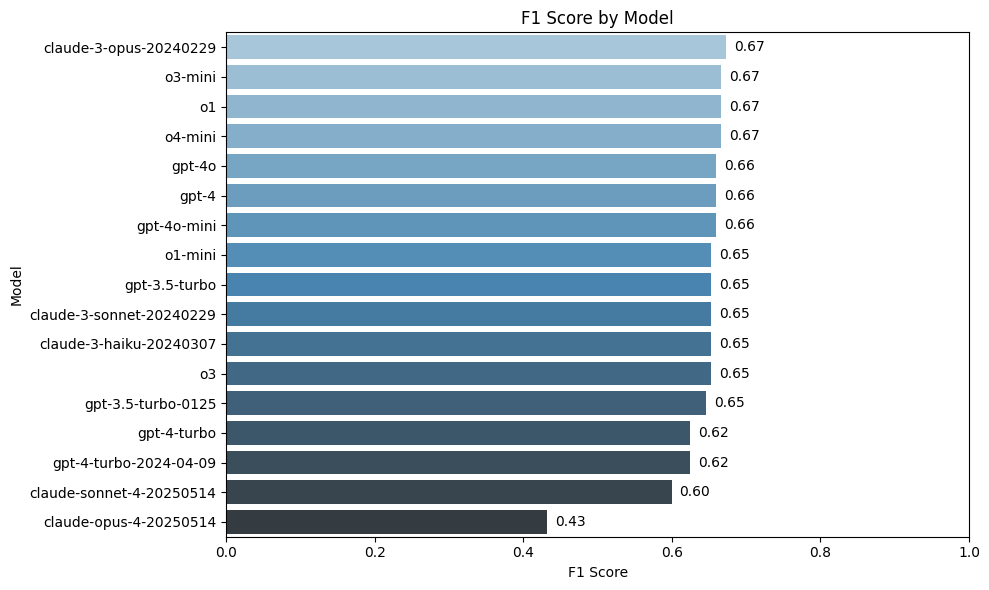

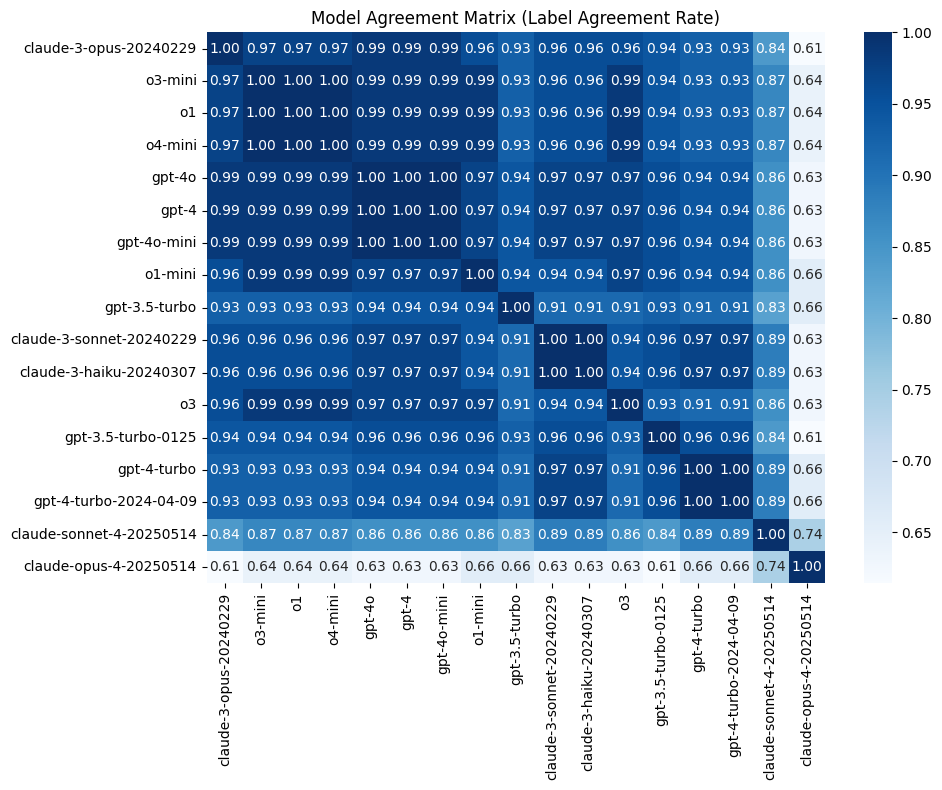

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Combine results and save
df_all_models = pd.concat(all_results, ignore_index=True)
df_all_models.to_csv("judge_results_all_models.csv", index=False)

# Compute metrics
metrics = []
models = df_all_models["model"].unique()

for model_name in models:
    df_model = df_all_models[df_all_models["model"] == model_name]

    # Keep only valid predictions and labels
    df_model = df_model[
        df_model["label"].isin(["correct", "incorrect"]) &
        df_model["true_label"].isin(["correct", "incorrect"])
    ]

    # Use real ground truth, given we added some incorrect examples
    true_labels = df_model["true_label"].tolist()
    pred_labels = df_model["label"].tolist()

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, pos_label="correct", zero_division=0)
    recall = recall_score(true_labels, pred_labels, pos_label="correct", zero_division=0)
    f1 = f1_score(true_labels, pred_labels, pos_label="correct", zero_division=0)

    metrics.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Create dataframe and sort it
df_metrics = pd.DataFrame(metrics)
df_metrics_sorted = df_metrics.sort_values("F1 Score", ascending=False)

# Preserve order of models for plotting
model_order = df_metrics_sorted["Model"].tolist()

# Plot with fixed order
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_metrics_sorted,
    x="F1 Score",
    y="Model",
    palette="Blues_d",
    order=model_order
)
plt.title("F1 Score by Model")
plt.xlim(0, 1)

# Add labels at correct y-axis positions
for i, model in enumerate(model_order):
    score = df_metrics_sorted[df_metrics_sorted["Model"] == model]["F1 Score"].values[0]
    ax.text(score + 0.01, i, f"{score:.2f}", va='center')

plt.tight_layout()
plt.show()

# ---- Generate agreement Matrix for models -------

# Generate a consistent ID for each example
df_all_models["example_id"] = df_all_models.groupby("model").cumcount()

# Pivot to wide format: one row per example, one column per model
df_pivot = df_all_models.pivot(index="example_id", columns="model", values="label")

# Compute agreement rates between models
agreement_matrix = pd.DataFrame(index=model_order, columns=model_order)

for m1 in model_order:
    for m2 in model_order:
        agreement = (df_pivot[m1] == df_pivot[m2]).mean()
        agreement_matrix.loc[m1, m2] = agreement

agreement_matrix = agreement_matrix.astype(float)

# ----------------------------------------
# Plot Agreement Heatmap
# ----------------------------------------

plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("Model Agreement Matrix (Label Agreement Rate)")
plt.tight_layout()
plt.show()